#**Name: Lujain Mahmoud Darwish    ID: 19105985**

# CNN Classifier for Dental Implants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import shutil

## Download dataset

In [2]:
#install to download the dataset easily
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
#download dataset
!gdown 18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21

Downloading...
From: https://drive.google.com/uc?id=18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21
To: /content/Dental.rar
100% 40.1M/40.1M [00:01<00:00, 23.1MB/s]


In [4]:
#unzip dataset
!unrar x "/content/Dental.rar" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Dental.rar

Creating    Dental                                                    OK
Creating    Dental/Argon                                              OK
Extracting  Dental/Argon/1252.PNG                                          0%  OK 
Extracting  Dental/Argon/170861378_181773640455697_8868278685022032298_n_03.jpg       0%  OK 
Extracting  Dental/Argon/170997132_181773687122359_801184412197855815_n_03.jpg       0%  OK 
Extracting  Dental/Argon/172042944_181773760455685_5660686353046769448_n_03.jpg       0%  OK 
Extracting  Dental/Argon/2123.PNG                                          0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_03.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_06.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283

## read and plot image

(252, 138, 4)


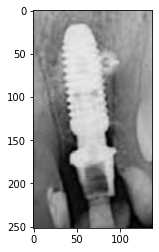

In [5]:
# Read and plot image 
def read_and_display(image):
    image = plt.imread(image)
    plt.imshow(image)
    print(image.shape)
    
read_and_display("/content/Dental/Argon/2123.PNG")

In [6]:
source = '/content/Dental'

print("Number of classes before del = ", len(os.listdir(source)))

Number of classes before del =  60


In [7]:
for f in os.listdir(source):  
    images = os.listdir(os.path.join(source, f))
    n_images = len(images)
    if n_images < 25 : 
        shutil.rmtree(os.path.join(source, f), ignore_errors=True)

print("Number of classes after del = ", len(os.listdir(source)))

Number of classes after del =  41


In [8]:
classes_list = os.listdir(source)

print(classes_list)

num_classes = len(classes_list)

['Flotechno', 'Neoss', 'Bicon', 'BRAT', 'Blue Sky Bio', 'NDI', 'Nucleoss', 'C-tech', 'Vitronex', 'Zimmer', 'Neobiotech', 'Dual', 'Biomet3i', 'Shutz', 'Hiossen', 'Ritter', 'Humantech', 'ROOTT', 'ETK', 'SIC', 'TUT', 'Argon', 'Astratech', 'Bilimplant', 'solvo', 'BioInfinity Implant', 'Dentis', 'PTI', 'BTK', 'SGS', 'Green', 'Dentium', 'Megagen', 'BioHorizons', 'Detech', 'B&B Dental', 'biodem', 'Straumann', 'Chaoram', 'JDentalCare', 'Bredent']


## Train/test split

In [9]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import splitfolders
# Split with a ratio.
splitfolders.ratio("/content/Dental", output="/content/data", 
                   seed=816, ratio=(.85, .075, .075), 
                   group_prefix=None)

Copying files: 2173 files [00:00, 7547.88 files/s]


### Create dataset generator
First step is to create a dataset generator which will be given to the model to train from.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import concatenate

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        # rotation_range=45,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='wrap')  

In [13]:
batch_size = 64
img_height = 224
img_width = 224
image_size = (img_height, img_width)
inputs = Input((img_height, img_width, 3))

In [14]:
train_dir = '/content/data/train'
train_generator=datagen.flow_from_directory(
                        directory=train_dir,
                        batch_size=batch_size,
                        seed=50,
                        shuffle=True,
                        class_mode="categorical",
                        color_mode="rgb",
                        target_size=image_size)

Found 1828 images belonging to 41 classes.


In [15]:
val_dir = '/content/data/val'
valid_generator=datagen.flow_from_directory(
                        directory=val_dir,
                        batch_size=batch_size,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        color_mode="rgb",
                        target_size=image_size)

Found 144 images belonging to 41 classes.


In [16]:
test_dir = '/content/data/test'
test_generator=datagen.flow_from_directory(
                            directory=test_dir,
                            batch_size=1,
                            seed=42,
                            shuffle=True,
                            class_mode="categorical",
                            color_mode="rgb",
                            target_size=image_size)

Found 201 images belonging to 41 classes.


In [17]:
STEP_SIZE_TRAIN=len(train_generator)
STEP_SIZE_VALID=len(valid_generator)
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

29
3


## Models building

By using GoogleNet architecture

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


In [ ]:
def GoogLeNet(input_layer):
  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(60, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(60, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(60, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
googlenet_model = GoogLeNet(inputs)

In [ ]:
googlenet_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 125, 125, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 62, 62, 64)   0           ['conv2d[0][0]']                 
                                                                                          

In [ ]:
googlenet_model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='max', patience=5,  restore_best_weights=True)

filepath="/content/" + "googlenet_weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, es]

In [ ]:
googlenet_hist_model = googlenet_model.fit(
                    train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    shuffle = True, 
                    callbacks=callbacks_list)

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 12.6345 - dense_6_loss: 4.0727 - dense_3_loss: 4.4276 - dense_5_loss: 4.1342 - dense_6_accuracy: 0.0608 - dense_3_accuracy: 0.0430 - dense_5_accuracy: 0.0481
Epoch 1: val_loss improved from inf to 11.42970, saving model to /content/googlenet_weights.h5
79/79 [==============================] - 136s 2s/step - loss: 12.6345 - dense_6_loss: 4.0727 - dense_3_loss: 4.4276 - dense_5_loss: 4.1342 - dense_6_accuracy: 0.0608 - dense_3_accuracy: 0.0430 - dense_5_accuracy: 0.0481 - val_loss: 11.4297 - val_dense_6_loss: 3.8404 - val_dense_3_loss: 3.8029 - val_dense_5_loss: 3.7864 - val_dense_6_accuracy: 0.1000 - val_dense_3_accuracy: 0.0333 - val_dense_5_accuracy: 0.1000
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 11.7652 - dense_6_loss: 3.9169 - dense_3_loss: 3.9416 - dense_5_loss: 3.9068 - dense_6_accuracy: 0.0278 - dense_3_accuracy: 0.0506 - dense_5_accuracy: 0.0456
Epoch 2: val_loss did not improve from 

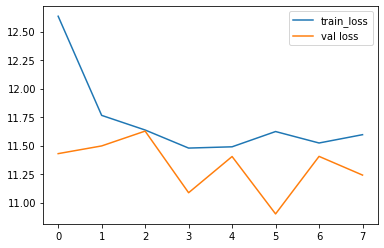

In [ ]:
# Plot the Loss
plt.plot(googlenet_hist_model.history['loss'], label = 'train_loss')
plt.plot(googlenet_hist_model.history['val_loss'], label ='val loss')
plt.legend()
plt.show()